In [1]:
import sys
sys.path.append('../..')

from anthropic import Anthropic
from lib.automated_evaluation import  caesar_decrypt
from transformers import AutoTokenizer
import pickle
import pandas as pd
from tqdm import tqdm
import torch
import json
keys_file_path = "/root/keys"
with open(keys_file_path, 'r') as keys_file:
    keys = json.load(keys_file)

token = keys["TOKEN_NAME"]
import os
import numpy as np
import re
import json
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
system_prompt = "You are a helpful, honest and concise assistant."  # Needed for chat model


In [2]:
from sklearn.decomposition import PCA

def pca_transform(data1, data2, n_components):
    """
    Transforms data arrays using PCA.

    Parameters:
    - data1, data2: torch.Tensor or np.array
    - n_components: int, number of PCA components to retain

    Returns:
    - transformed_data1, transformed_data2: np.array, np.array
    """

    all_data = torch.cat([data1, data2], dim=0).numpy()
    average_vector = all_data.mean(axis=0)
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(all_data - average_vector)

    n_data1 = data1.shape[0]
    transformed_data1 = pca_results[:n_data1]
    transformed_data2 = pca_results[n_data1:]

    return transformed_data1, transformed_data2


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


def svm_separation(data1, data2, test_size=0.5, random_state=42):
    """
    Calculates the SVM separation plane and returns its normal vector and the classification accuracy.

    Parameters:
    - data1, data2: np.array, np.array
    - test_size: float, proportion of the data to use as a test set
    - random_state: int, random seed for train-test split

    Returns:
    - weight_vector: np.array, normal of the separating plane
    - accuracy: float, classification accuracy on the test set
    """
    data = np.vstack([data1, data2])
    labels = np.hstack([np.ones(data1.shape[0]), np.zeros(data2.shape[0])])
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)
    clf = SVC(kernel='linear')
    clf.fit(X_train, y_train)
    
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    weight_vector = clf.coef_.flatten()

    return weight_vector, accuracy, clf

In [4]:
question_type = "direct_questions"
layer = 15
fiction_path = f"{question_type}/fiction/all_diffs_layer_{layer}.pt"
fiction_activations = torch.load(fiction_path)
negative_fiction_activations = -torch.load(fiction_path)

fiction_pca, negatice_fiction_pca = pca_transform(fiction_activations, negative_fiction_activations, 2)
fiction_weight, fiction_accuracy, clf = svm_separation(fiction_pca, negatice_fiction_pca)

In [5]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'

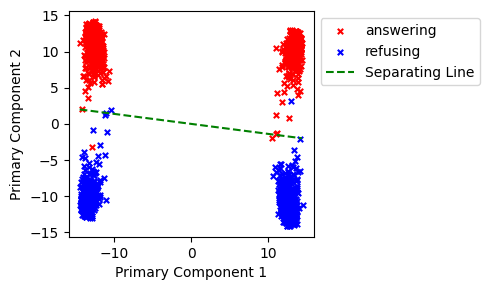

In [7]:
import numpy as np


# Define a range of x values for plotting
x_range = np.linspace(min(fiction_pca[:, 0]), max(fiction_pca[:, 0]), 100)

# Calculate corresponding y values for the separating line
y_separating = (-fiction_weight[0]/fiction_weight[1]) * x_range - clf.intercept_[0] / fiction_weight[1]
plt.figure(figsize=(5, 3))
plt.scatter(fiction_pca[:, 0], fiction_pca[:, 1], label="answering", color="red", marker="x", s=15)
plt.scatter(negatice_fiction_pca[:, 0], negatice_fiction_pca[:, 1], label="refusing", color="blue", marker="x", s=15)
plt.plot(x_range, y_separating, 'g--', label='Separating Line')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Primary Component 1")
plt.ylabel("Primary Component 2")
plt.tight_layout()

# Define the path to save the images
data_folder = "./pca_plots"  # Modify this to your specific path
image_name = "seperation_line"
plt.savefig(f"{data_folder}/{image_name}.png", format="png", dpi=300, bbox_inches='tight')  # Saving as PNG with higher dpi
plt.savefig(f"{data_folder}/{image_name}.svg", format="svg", bbox_inches='tight')  # Saving as SVG

plt.show()


In [8]:
pca_dims = range(1, 20)
fiction_accuracies = []

for n_components in pca_dims:
    fiction_pca, negatice_fiction_pca = pca_transform(fiction_activations, negative_fiction_activations, n_components)
    fiction_weight, fiction_accuracy, clf = svm_separation(fiction_pca, negatice_fiction_pca)
    fiction_accuracies.append(fiction_accuracy)
    

In [9]:
question_type = "direct_questions"
layer = 15
fiction_path = f"{question_type}/fiction/all_diffs_layer_{layer}.pt"
fiction_activations = -torch.load(fiction_path)
truth_path = f"{question_type}/truth/all_diffs_layer_{layer}.pt"
truth_activations = torch.load(truth_path)

pca_dims = range(1, 20)
accuracies = []

for n_components in pca_dims:
    fiction_pca, truth_pca = pca_transform(fiction_activations, truth_activations, n_components)
    weight, accuracy, clf = svm_separation(fiction_pca, truth_pca)
    accuracies.append(accuracy)
    

KeyboardInterrupt: 

In [9]:
pca_dims = range(1, 20)
mixed_accuracies = []
question_type = "direct_questions"
layer = 15
mixed_path = f"{question_type}/mixed/all_diffs_layer_{layer}.pt"
mixed_activations = torch.load(mixed_path)
negative_mixed_activations = -torch.load(mixed_path)

for n_components in pca_dims:
    mixed_pca, negatice_mixed_pca = pca_transform(mixed_activations, negative_mixed_activations, n_components)
    mixed_weithts, mixed_accuracy, clf = svm_separation(mixed_pca, negatice_mixed_pca)
    mixed_accuracies.append(mixed_accuracy)

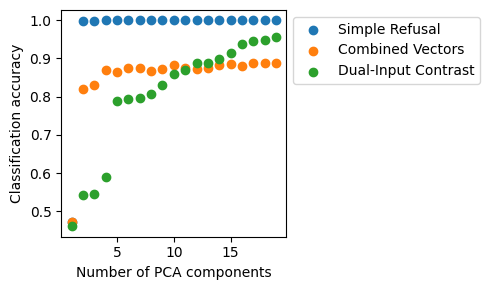

In [10]:
# Plot the results
plt.figure(figsize=(5, 3))
plt.scatter(pca_dims, fiction_accuracies, label="Simple Refusal")
plt.scatter(pca_dims, accuracies, label="Combined Vectors")
plt.scatter(pca_dims, mixed_accuracies, label="Dual-Input Contrast")
plt.xlabel("Number of PCA components")
plt.ylabel("Classification accuracy")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Define the path to save the images
data_folder = "./pca_plots"  # Modify this to your specific path
image_name = "pca_accuracy"
plt.savefig(f"{data_folder}/{image_name}.png", format="png", dpi=300, bbox_inches='tight')  # Saving as PNG with higher dpi
plt.savefig(f"{data_folder}/{image_name}.svg", format="svg", bbox_inches='tight')  # Saving as SVG

plt.show()


In [14]:
question_type = "direct_questions"
layer = 15
fiction_path = f"{question_type}/fiction/all_diffs_layer_{layer}.pt"
truth_path = f"{question_type}/truth/all_diffs_layer_{layer}.pt"
fiction_activations = -torch.load(fiction_path)
truth_activations = torch.load(truth_path)

fiction_pca, truth_pca = pca_transform(fiction_activations, truth_activations, 3)
wight, accuracy, clf = svm_separation(fiction_pca, truth_pca)

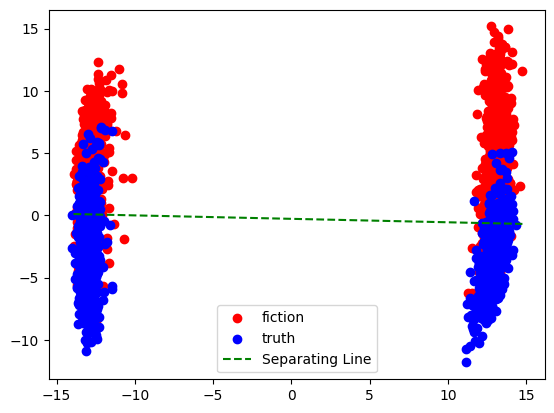

In [15]:
import numpy as np
import matplotlib.pyplot as plt


# Define a range of x values for plotting
x_range = np.linspace(min(fiction_pca[:, 0]), max(fiction_pca[:, 0]), 100)

# Calculate corresponding y values for the separating line
y_separating = (-wight[0]/wight[1]) * x_range - clf.intercept_[0] / wight[1]

plt.scatter(fiction_pca[:, 0], fiction_pca[:, 1], label="fiction", color="red")
plt.scatter(truth_pca[:, 0], truth_pca[:, 1], label="truth", color="blue")
plt.plot(x_range, y_separating, 'g--', label='Separating Line')
plt.legend()
plt.show()


In [13]:
layers = [layer for layer in range(13,30)]
question_types = ["direct_questions", "alluding_questions", "conversation", "questioning_assuming_statement"]
pca_dimension = 4
layer_accuracies = {}

# Outer progress bar for question types
for question_type in question_types:
    print(f"Processing layers for {question_type}")
    layer_accuracies[question_type] = []

    # Inner progress bar for layers
    for layer in tqdm(layers, desc=f"Processing layers for {question_type}", leave=False):
        fiction_path = f"{question_type}/fiction/all_diffs_layer_{layer}.pt"
        truth_path = f"{question_type}/truth/all_diffs_layer_{layer}.pt"
        fiction_activations = -torch.load(fiction_path)
        truth_activations = torch.load(truth_path)
        fiction_pca, truth_pca = pca_transform(fiction_activations, truth_activations, pca_dimension)
        weight, accuracy, clf = svm_separation(fiction_pca, truth_pca)
        layer_accuracies[question_type].append(accuracy)

Processing layers for direct_questions


Processing layers for alluding_questions


Processing layers for conversation


Processing layers for questioning_assuming_statement


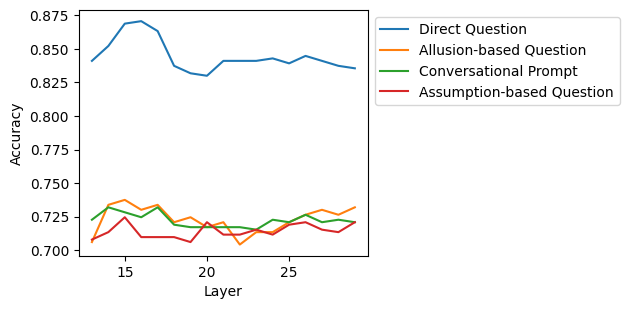

In [14]:
plt.figure(figsize=(6.2, 3))
question_type_names = ["Direct Question", "Allusion-based Question", "Conversational Prompt", "Assumption-based Question"]
for question_type, name  in zip(question_types, question_type_names):
    plt.plot(layers, layer_accuracies[question_type], label=name)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.xlabel("Layer")
plt.ylabel("Accuracy")

# Define the path to save the images
data_folder = "./pca_plots"  # Modify this to your specific path
image_name = "layer_accuracy"
plt.savefig(f"{data_folder}/{image_name}.png", format="png", dpi=300, bbox_inches='tight')  # Saving as PNG with higher dpi
plt.savefig(f"{data_folder}/{image_name}.svg", format="svg", bbox_inches='tight')  # Saving as SVG

plt.show()

In [15]:
mixed_accuracies = {}
mixed_pca_dims = 13

# Outer progress bar for question types
for question_type in question_types:
    print(f"Processing layers for {question_type}")
    mixed_accuracies[question_type] = []

    # Inner progress bar for layers
    for layer in tqdm(layers, desc=f"Processing layers for {question_type}", leave=False):
        mixed_path = f"{question_type}/mixed/all_diffs_layer_{layer}.pt"
        mixed_activations = torch.load(mixed_path)
        negative_mixed_activations = -torch.load(mixed_path)
        mixed_pca, neg_mixed_pca = pca_transform(mixed_activations, negative_mixed_activations, mixed_pca_dims)
        weight, accuracy, clf = svm_separation(mixed_pca, neg_mixed_pca)
        mixed_accuracies[question_type].append(accuracy)

Processing layers for direct_questions


Processing layers for alluding_questions


Processing layers for conversation


Processing layers for questioning_assuming_statement


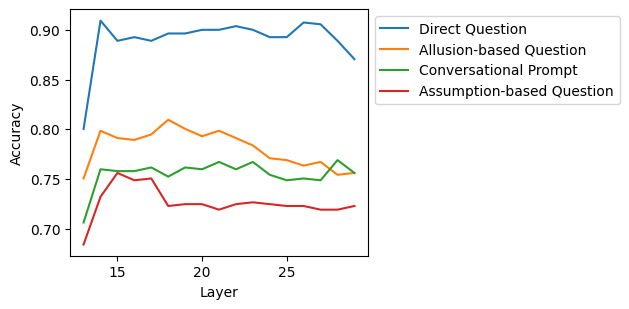

In [16]:
plt.figure(figsize=(6.2, 3))
question_type_names = ["Direct Question", "Allusion-based Question", "Conversational Prompt", "Assumption-based Question"]
for question_type, name  in zip(question_types, question_type_names):
    plt.plot(layers, mixed_accuracies[question_type], label=name)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.xlabel("Layer")
plt.ylabel("Accuracy")

# Define the path to save the images
data_folder = "./pca_plots"  # Modify this to your specific path
image_name = "mixed_layer_accuracy"
plt.savefig(f"{data_folder}/{image_name}.png", format="png", dpi=300, bbox_inches='tight')  # Saving as PNG with higher dpi
plt.savefig(f"{data_folder}/{image_name}.svg", format="svg", bbox_inches='tight')  # Saving as SVG

plt.show()

In [17]:
simple_accuracy = {}
simple_pca_dims = 2

# Outer progress bar for question types
for question_type in question_types:
    print(f"Processing layers for {question_type}")
    simple_accuracy[question_type] = []


    # Inner progress bar for layers
    for layer in tqdm(layers, desc=f"Processing layers for {question_type}", leave=False):
        fiction_path = f"{question_type}/fiction/all_diffs_layer_{layer}.pt"
        fiction_activations = torch.load(fiction_path)
        negative_fiction_activations = -torch.load(fiction_path)
        mixed_pca, neg_mixed_pca = pca_transform(fiction_activations, negative_fiction_activations, simple_pca_dims)
        weight, accuracy, clf = svm_separation(mixed_pca, neg_mixed_pca)
        simple_accuracy[question_type].append(accuracy)

Processing layers for direct_questions


Processing layers for alluding_questions


Processing layers for conversation


Processing layers for questioning_assuming_statement


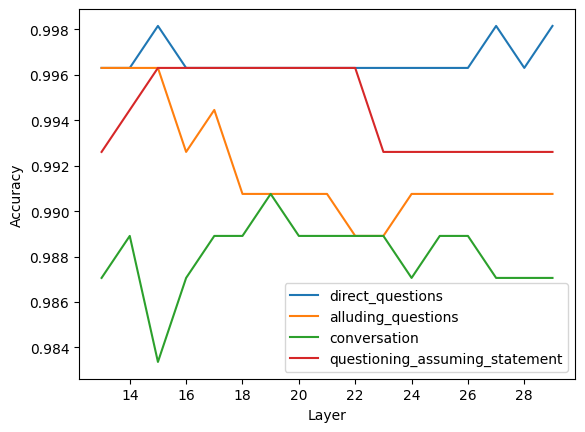

In [18]:
for question_type in question_types:
    plt.plot(layers, simple_accuracy[question_type], label=question_type)
plt.legend()
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.show()